## Airbus Ship Detection
### Custom Unet model

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from keras import backend as K
import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers import Input, UpSampling2D, Conv2D, MaxPooling2D, Activation, Concatenate
from keras.optimizers import adam_v2

#### Functions

In [2]:
def object_dims(encodedpixels):              # return ship size
    encodedpixels = np.array(list(zip(*[iter(int(x) for x in encodedpixels.split())]*2)))
    return np.max(encodedpixels[:,1]), len(encodedpixels)  

def rle_decode(mask_rle, shape=(768, 768)):  # return image from mask
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  

#### Metrics

In [3]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_keras = true_positives / (possible_positives + K.epsilon())
    return recall_keras


def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_keras = true_positives / (predicted_positives + K.epsilon())
    return precision_keras


def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

### Data preprocessing

In [4]:
masks = pd.read_csv('train_ship_segmentations_v2.csv')
masks.head(3)

ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...

Dataframe include rows with names of the images in 'train_v2' folder and encoded pixels belong to mask for ships on the images.

#### Check the size and number of channels of the image

In [39]:
images = masks.ImageId.unique()
counter = {}
for i in images:
    img = cv2.imread('train_v2/'+ i)
    shape = img.shape
    if img.shape not in counter.keys():
        counter[img.shape] = 0
    counter[img.shape] += 1
counter

Premature end of JPEG file


{(768, 768, 3): 192556}

All images are 768x768 pixels and 3 channels.

In [17]:
train_dir = os.path.join('train_v2')
print('Files in directory:', len(os.listdir(train_dir)))
print('Rows in dataframe:', len(masks))
print('Unique images in dataframe:', len(masks.ImageId.unique()))

Files in directory: 192556
Rows in dataframe: 231723
Unique images in dataframe: 192556


230k rows and 190k unique images. This means that there can be several masks for one image.

Some images has no masks. This mean that some images are without ships.

### No. images with ships and without ships

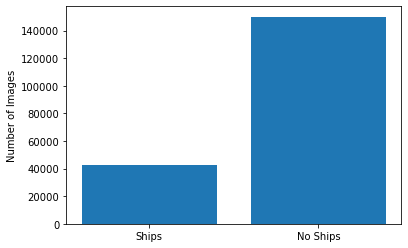

In [40]:
ships = masks[~masks.EncodedPixels.isna()].ImageId.unique()
noships = masks[masks.EncodedPixels.isna()].ImageId.unique()

plt.bar(['Ships', 'No Ships'], [len(ships), len(noships)]);
plt.ylabel('Number of Images');

### Random images without ships

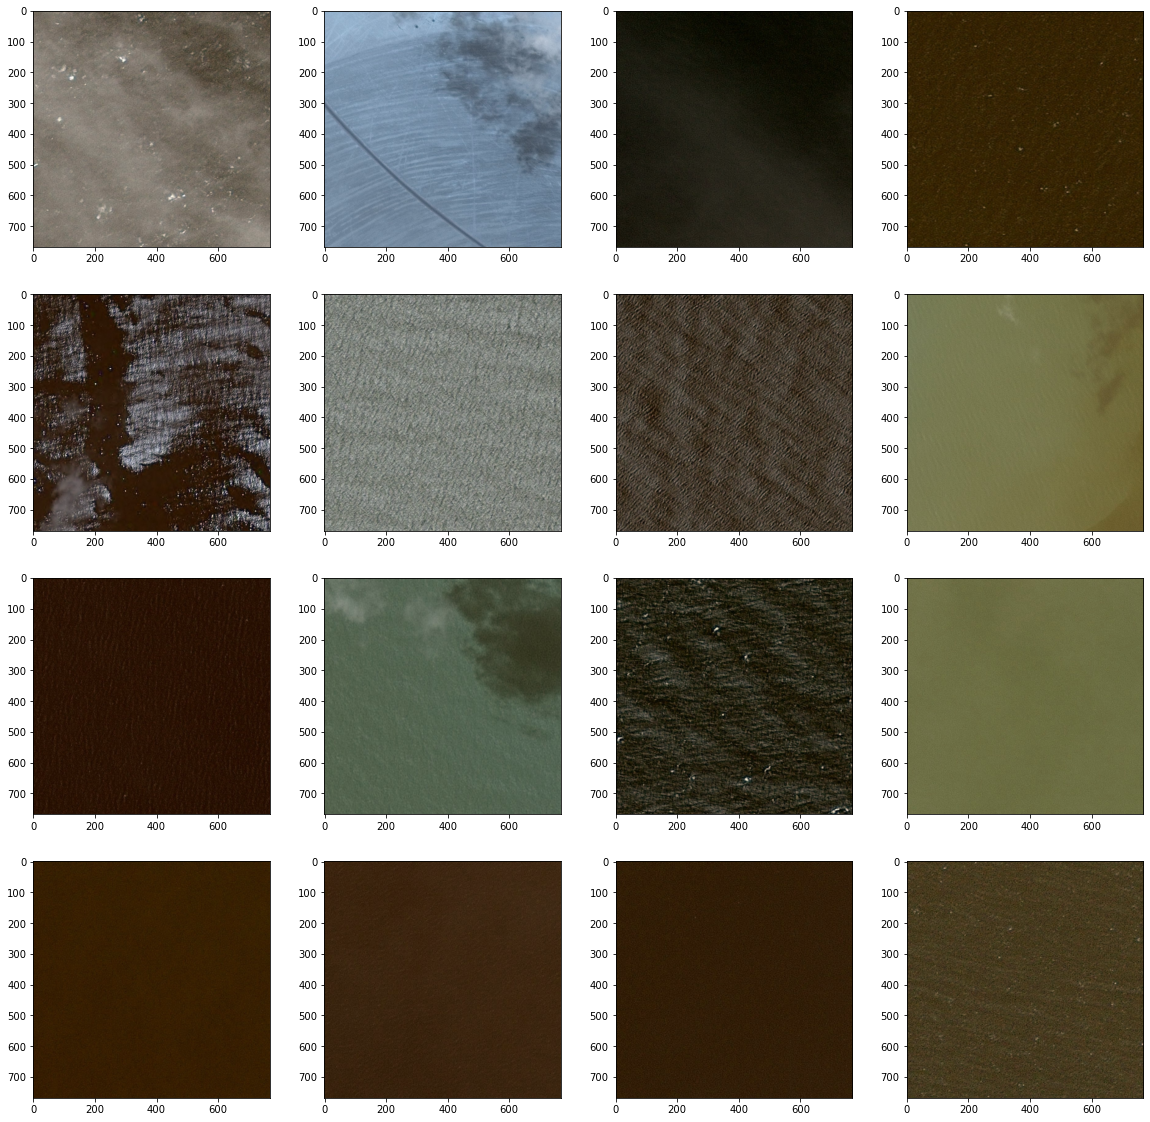

In [18]:
sampl = masks[masks.EncodedPixels.isna()]
fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = (20, 20))
for i in range(4):
    for n in range (4):
        axes[i][n].imshow(cv2.imread('train_v2/'+ sampl.ImageId.sample(1).values[0]))
plt.show()        

### Random images with ships

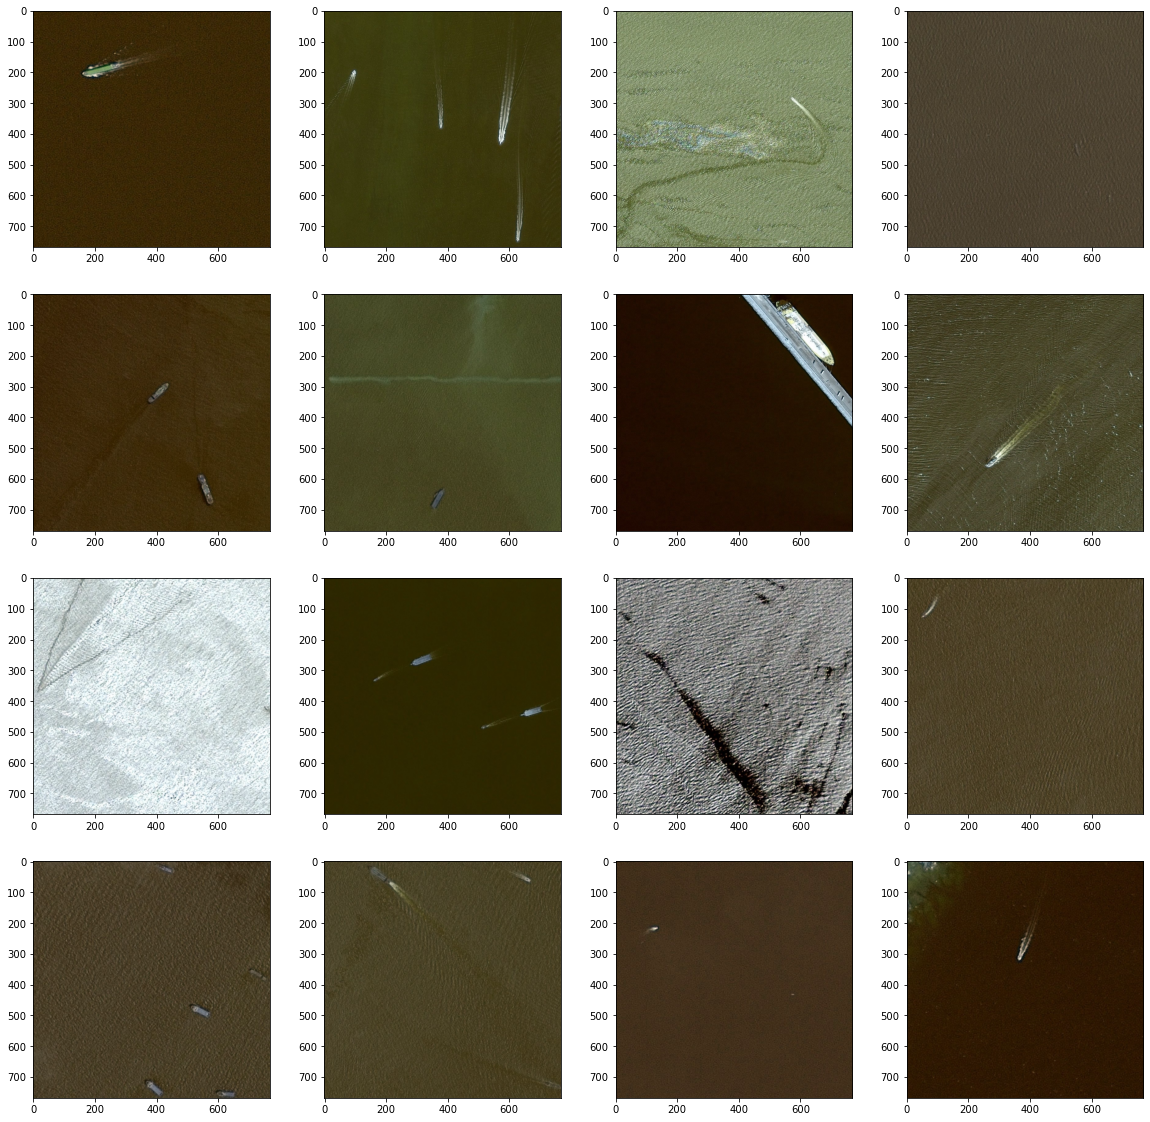

In [42]:
sampl = masks[~masks.EncodedPixels.isna()]
fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = (20, 20))
for i in range(4):
    for n in range (4):
        axes[i][n].imshow(cv2.imread('train_v2/'+ sampl.ImageId.sample(1).values[0]))
plt.show()        

### Distribution of ships number in the images with ships

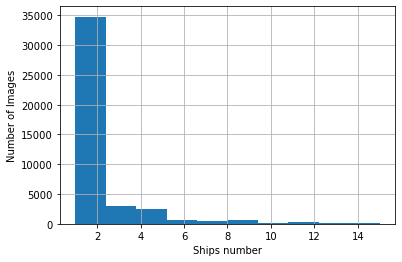

In [43]:
ships_no = masks[~masks.EncodedPixels.isna()].ImageId.value_counts()
ships_no.hist()
plt.ylabel('Number of Images');
plt.xlabel('Ships number');

In [44]:
ships_no.describe()

count    42556.000000
mean         1.920364
std          1.906073
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         15.000000
Name: ImageId, dtype: float64

### Distribution of ships size in pixels

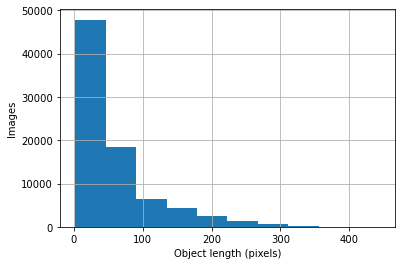

In [46]:
obj_maxdim = masks.dropna().EncodedPixels.map(lambda x: max(object_dims(x)))
obj_maxdim.hist()
plt.xlabel('Object length (pixels)');
plt.ylabel('Images');

In [47]:
obj_maxdim.describe()

count    81723.000000
mean        57.077445
std         58.253226
min          2.000000
25%         16.000000
50%         35.000000
75%         76.000000
max        444.000000
Name: EncodedPixels, dtype: float64

### Class balance

In [48]:
ship_pixels = sum(masks.dropna().EncodedPixels.map(lambda x: object_dims(x)[0]*object_dims(x)[1]))

In [49]:
ratio = ship_pixels / total_pixels
print(f"Pixels with ships: {round(ratio, 3)} ({ship_pixels})")
print(f"Pixels without ships: {round(1 - ratio, 3)} ({total_pixels - ship_pixels})")

Pixels with ships: 0.003 (157080347)
Pixels without ships: 0.997 (48045106405)


The belonging of each pixel to the "ship" class will be evaluated, but less than 1% of pixels are ships while > 99% of pixels are not ships. This means that the dataset is very unbalanced.

For training will merge all the masks for each image and remowe images without ships.

### Split data to train, validation and test sets (70:28:2)

In [5]:
train_df = masks[:230000]
test_df = masks[230000:]
test_df.reset_index(drop=True, inplace=True)
train_df = train_df.dropna(axis='index')
test_df = test_df.fillna('')                      # get rid of NaN

#### Check for corrupted images (size less then 50 kb)

In [22]:
train_df['file_size_kb'] = train_df.ImageId.map(lambda x: os.stat(os.path.join(train_dir, x)).st_size/1024)
print(f"amount of corrupted images: {len(train_df[train_df['file_size_kb'] < 50])}")

amount of corrupted images: 928


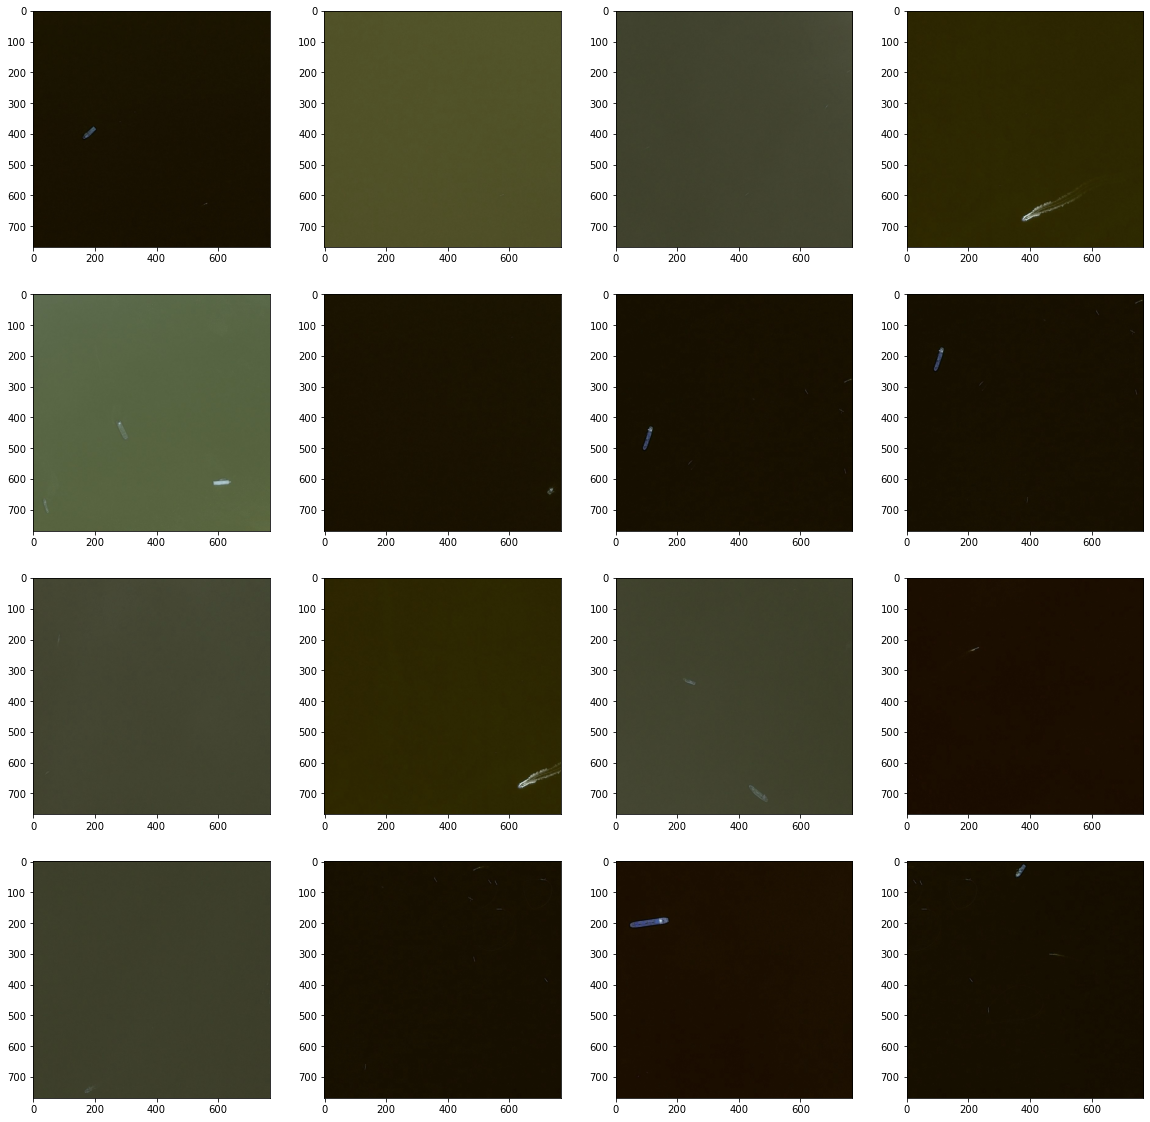

In [25]:
sampl = train_df[train_df['file_size_kb'] < 50]
fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = (20, 20))
for i in range(4):
    for n in range (4):
        axes[i][n].imshow(cv2.imread('train_v2/'+ sampl.ImageId.sample(1).values[0]))
plt.show() 

No need to delete these images.

In [6]:
train_df, val_df = train_test_split (train_df, test_size = 0.3, random_state = 42)

### Generator images (to reduce memory usage)

In [7]:
def img_generator(gen_df, batch_size):                            
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            img_name, mask_rle = gen_df.sample(1).values[0]      # get row from DF
            img = cv2.imread('train_v2/'+ img_name)              # read img
            

            img_masks = masks.loc[masks['ImageId'] == img_name, 'EncodedPixels'].tolist()

            all_masks = np.zeros((768, 768))                     # find ship masks for more the one ship                   
            for mask in img_masks:                               # create a single mask for all ships
                if type(mask) == str:
                    all_masks += rle_decode(mask) 
            

            img = cv2.resize(img, (256, 256))                    # resize img to 256,256
            mask = cv2.resize(all_masks, (256, 256))             # resize mask to 256,256
            
            
            x_batch += [img]                                     # put into batch
            y_batch += [mask]

        x_batch = np.array(x_batch) / 255.                       # reduce color dimension img
        y_batch = np.array(y_batch)

        yield x_batch, np.expand_dims(y_batch, -1)               # return batch

#### How generators and decoding works

In [37]:
for x, y in img_generator(train_df, 16):                                                 
    break
print('Output shapes (images and masks):', x.shape, y.shape)       

Output shapes (images and masks): (16, 256, 256, 3) (16, 256, 256, 1)


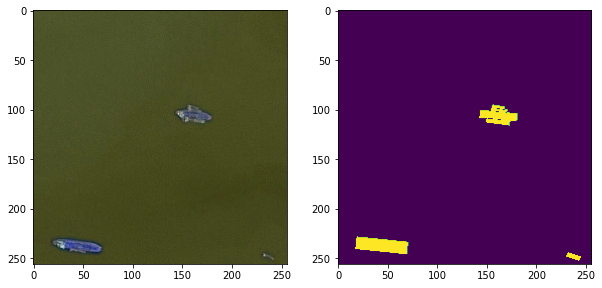

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].imshow(x[2])
axes[1].imshow(y[2])
plt.show()

'img_generator' return batch with images and their masks.

### Make the Model

In [8]:
inp = Input(shape=(256, 256, 3))                               # input layer with shape 256x256 and 3 chanels



conv_1_1 = Conv2D(32, (3, 3), padding = 'same')(inp)           # increase filters number to 32, kernel size 3x3
conv_1_1 = Activation('relu')(conv_1_1)

conv_1_2 = Conv2D(32, (3, 3), padding = 'same')(conv_1_1)
conv_1_2 = Activation('relu')(conv_1_2)

pool_1 = MaxPooling2D(2)(conv_1_2)                             # reduce image size 



conv_2_1 = Conv2D(64, (3, 3), padding = 'same')(pool_1)        # increase filters number to 64
conv_2_1 = Activation('relu')(conv_2_1)

conv_2_2 = Conv2D(64, (3, 3), padding = 'same')(conv_2_1)
conv_2_2 = Activation('relu')(conv_2_2)

pool_2 = MaxPooling2D(2)(conv_2_2)                             # reduce image size 



conv_3_1 = Conv2D(128, (3, 3), padding = 'same')(pool_2)       # increase filters number to 128
conv_3_1 = Activation('relu')(conv_3_1)

conv_3_2 = Conv2D(128, (3, 3), padding = 'same')(conv_3_1)
conv_3_2 = Activation('relu')(conv_3_2)

pool_3 = MaxPooling2D(2)(conv_3_2)                             # reduce image size



conv_4_1 = Conv2D(256, (3, 3), padding = 'same')(pool_3)       # increase filters number to 256
conv_4_1 = Activation('relu')(conv_4_1)

conv_4_2 = Conv2D(256, (3, 3), padding = 'same')(conv_4_1)
conv_4_2 = Activation('relu')(conv_4_2)

pool_4 = MaxPooling2D(2)(conv_4_2)                             # reduce image size



up_1 = UpSampling2D(2, interpolation = 'bilinear')(pool_4)     # increase image size

conc_1 = Concatenate()([conv_4_2, up_1])                       # concatenate withe the same size layer before upsampling to get low level info

conv_up_1_1 = Conv2D(256, (3, 3), padding = 'same')(conc_1)
conv_up_1_1 = Activation('relu')(conv_up_1_1)

conv_up_1_2 = Conv2D(256, (3, 3), padding = 'same')(conv_up_1_1)
conv_up_1_2 = Activation('relu')(conv_up_1_2)



up_2 = UpSampling2D(2, interpolation = 'bilinear')(conv_up_1_2) # increase image size

conc_2 = Concatenate()([conv_3_2, up_2])                        # concatenate withe the same size layer before upsampling to get low level info

conv_up_2_1 = Conv2D(128, (3, 3), padding = 'same')(conc_2)     # reduce filter number to 128
conv_up_2_1 = Activation('relu')(conv_up_2_1)

conv_up_2_2 = Conv2D(128, (3, 3), padding = 'same')(conv_up_2_1)
conv_up_2_2 = Activation('relu')(conv_up_2_2)



up_3 = UpSampling2D(2, interpolation = 'bilinear')(conv_up_2_2) # increase image size

conc_3 = Concatenate()([conv_2_2, up_3])                        # concatenate withe the same size layer before upsampling to get low level info

conv_up_3_1 = Conv2D(64, (3, 3), padding = 'same')(conc_3)      # reduce filter number to 64
conv_up_3_1 = Activation('relu')(conv_up_3_1)

conv_up_3_2 = Conv2D(64, (3, 3), padding='same')(conv_up_3_1)
conv_up_3_2 = Activation('relu')(conv_up_3_2)



up_4 = UpSampling2D(2, interpolation = 'bilinear')(conv_up_3_2) # increase image size

conc_4 = Concatenate()([conv_1_2, up_4])                        # concatenate withe the same size layer before upsampling to get low level info

conv_up_4_1 = Conv2D(32, (3, 3), padding = 'same')(conc_4)      # reduce filter number to 32
conv_up_4_1 = Activation('relu')(conv_up_4_1)

conv_up_4_2 = Conv2D(1, (3, 3), padding = 'same')(conv_up_4_1)



result = Activation('sigmoid')(conv_up_4_2)                     # otput layer with sigmoid activation to get probability is a pixel ship


model = Model(inputs = inp, outputs = result)

2022-08-18 12:54:04.297163: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [9]:
best_w = keras.callbacks.ModelCheckpoint('unet_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('unet_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]



adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


model.compile(adam, 'binary_crossentropy', [f1, dice_coeff])

#### Fit the Model

In [ ]:
batch_size = 16

history = model.fit(img_generator(train_df, batch_size),
              steps_per_epoch=100,
              epochs=300,
              verbose=1,
              callbacks=callbacks,
              validation_data=img_generator(val_df, batch_size),
              validation_steps=10,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

10/10 [==============================] - ETA: 0s - loss: 0.4507 - f1: 0.0000e+00 - dice_coeff: 0.0096

#### Save the Model

In [ ]:
model.save('last_saved_model.h5')

#### Load the Model

In [41]:
model= load_model('last_saved_model.h5', custom_objects={'dice_coeff': dice_coeff, 'f1': f1})

#### How the Model was lerned

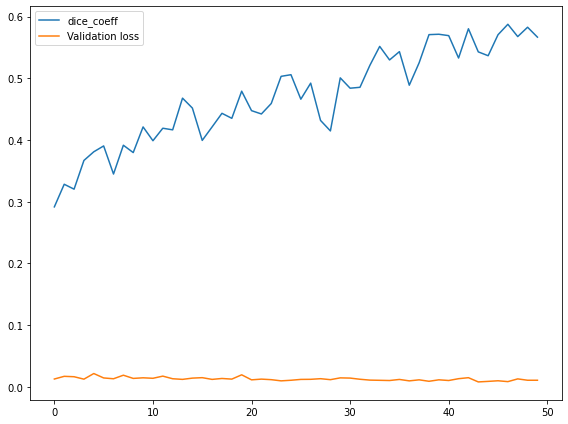

In [18]:
model_history = pd.DataFrame(history.history)
model_history['epoch'] = history.epoch

fig, ax = plt.subplots(1, figsize=(8,6))
num_epochs = model_history.shape[0]

ax.plot(np.arange(0, num_epochs), model_history["dice_coeff"], 
        label="dice_coeff")
ax.plot(np.arange(0, num_epochs), model_history["val_loss"], 
        label="Validation loss")
ax.legend()

plt.tight_layout()
plt.savefig('train_plot.png')
plt.show()

#### What model is predict

In [ ]:
for x, y in img_generator(test_df, len(test_df)):      
    break
y = np.float32(y)
pred = model.predict(x)

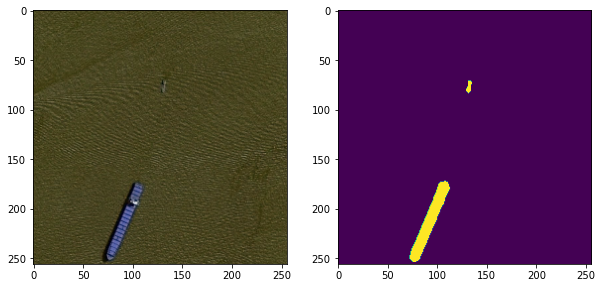

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].imshow(x[12])
axes[1].imshow(pred[12, ..., 0]>0.5 )
plt.show()

#### The Model Metrics

In [44]:
print('The f1-score: ', f1(y, pred))
print('The Dice coefficient: ', dice_coeff(y, pred))

The f1-score:  tf.Tensor(0.7458425, shape=(), dtype=float32)
The Dice coefficient:  tf.Tensor(0.5072613, shape=(), dtype=float32)


### Assessment

Finding ships in photos is a useful algorithm for border control and security. Even with a not very high rating, it can be used.

Given the upward curve on the training plot, the model can continue to be trained.

Given the large imbalance of classes, the model can be improved by working on images - cropping them and combining them.